In [1]:
import pandas as pd
import numpy as np
import pandas.core
import chainer.optimizers
from chainer import Sequential
import matplotlib.pyplot as plt

# constant setting
split_num = 10
n_input = 8
n_hidden = 20
n_output = 3
alpha = 0.0001
n_epoch = 50
batchsize = 16


/home/tubotu/.local/lib/python3.6/site-packages/chainer/backends/cuda.py:143: UserWarning: cuDNN is not enabled.
Please reinstall CuPy after you install cudnn
(see https://docs-cupy.chainer.org/en/stable/install.html#install-cudnn).
  'cuDNN is not enabled.\n'


In [2]:

def data_column_conversion(data:pandas.core.frame.DataFrame) -> pandas.core.frame.DataFrame:
    """
    Change the label element from str to int.

    @param data: the extracted data
    @return: the conversed data
    """
    data = data.assign(W = (data.label == 'W') + 0,D = (data.label == 'D') + 0,L = (data.label == 'L') + 0)
    data = data.drop("label",axis=1)
    return data


def data_randomization(data:pandas.core.frame.DataFrame) -> pandas.core.frame.DataFrame:
    """
    Randomize data.

    @param data: the conversed data you want to separate
    @return: the randomized data
    """
    return data.sample(n = len(data))


def data_separate(data:pandas.core.frame.DataFrame, split_num:int) -> list:
    """
    Separate data.
    
    @param data: the data you want to separate
    @param split_num: the division number for k-fold
    @return: separated data list
    """
    data_separate = []
    for i in range(split_num):
        data_separate.append(data[i::split_num])
    return data_separate


def data_list_wdl_merge(data_list1:list, data_list2:list) -> list:
    """
    Join two data lists by array number.
    
    @param data_list1: the data list you want to join
    @param data_list2: the data list you want to join
    @return: Joined data list
    """
    list_size = len(data_list1)
    merged_data_list = []
    for i in range(list_size):
        merged_data_list.append(pd.concat([data_list1[i],data_list2[i]]))
    return merged_data_list


def assign_group_numbers_to_data(data_list:list) -> list:
    """
    Assign group numbers to data.
    Group number is array numbers of data list.
    
    @param data_list: the data list you want to assign group numbers
    @return data_list
    """
    list_size = len(data_list)
    for i in range(list_size):
        data_list[i] = data_list[i].assign(separate_num=i)
    return data_list


def data_list_put_together(data_list:list) -> pandas.core.frame.DataFrame:
    """
    Combine the data list into one DataFrame.
    
    @param data_list: the data list you want to assign group numbers
    @return collected data
    """
    list_size = len(data_list)
    data = data_list[0]
    for i in range(1,list_size):
        data = data.append(data_list[i])
    return data


def making_dataset_list_train(data:pandas.core.frame.DataFrame, split_num:int) -> list:
    """
    Create training data set list for cross validation using group number.
    
    @param data: the collected data
    @param split_num: the division number for k-fold
    @return training data set list
    """
    train_data_list = []
    for i in range(split_num):
        train_data_list.append(data[data['separate_num'] != i])
    for i in range(split_num):
        train_data_list[i] = train_data_list[i].drop(['separate_num'], axis = 1)
    return train_data_list


def making_dataset_list_val(data:pandas.core.frame.DataFrame, split_num:int) -> list:
    """
    Create validation data set list for cross validation using group number.
    
    @param data: the collected data
    @param split_num: the division number for k-fold
    @return validation data set list
    """
    val_data_list = []
    for i in range(split_num):
        val_data_list.append(data[data['separate_num'] == i])
    for i in range(split_num):
        val_data_list[i] = val_data_list[i].drop(['separate_num'], axis = 1)
    return val_data_list


def making_dataset_list_x(data_list:list) -> list:
    """
    Create data set list for only explanatory variables.
    
    @param data_list: data set list
    @return: data set list for only explanatory variables
    """
    list_size = len(data_list)
    for i in range(list_size):
        data_list[i] = data_list[i].drop(["W","D","L"],axis=1)
    return data_list


def making_dataset_list_y(data_list:list) -> list:
    """
    Create data set list for only target variables.
    
    @param data_list: data set list
    @return: data set list for only target variables
    """
    list_size = len(data_list)
    data_list_y = []
    for i in range(list_size):
        data_list_y.append(data_list[i][["W","D","L"]])
    return data_list_y


def translate_pandas_to_numpy(data_list:list) -> list:
    """
    Convert pandas to numpy and make type 'float32'.
    
    @param data_list:pandas data set list
    @return: numpy data set list
    """
    list_size = len(data_list)
    for i in range(list_size):
        data_list[i] = data_list[i].values.astype('float32')
    return data_list


def data_processing_for_stratified_sampling(data:pandas.core.frame.DataFrame, split_num:int) -> pandas.core.frame.DataFrame:
    """
    Process the data for stratified sampling.
    
    @param data: inputted data
    @param split_num: the division number for k-fold
    @return: the data for stratified sampling
    """
    win_data = data[data.label == 'W'] # Extract only the data of label of win
    draw_data = data[data.label == 'D'] # Extract only the data of label of draw
    lose_data = data[data.label == 'L'] # Extract only the data of label of lose
    data_list = [win_data, draw_data, lose_data]
    for i,wdl_data in enumerate(data_list):
        wdl_data = data_column_conversion(wdl_data)
        wdl_data = data_randomization(wdl_data)
        if i == 0:
            separated_data_list = data_separate(wdl_data, split_num)
        else:
            separated_data_list = data_list_wdl_merge(separated_data_list, data_separate(wdl_data, split_num))
    separated_data_list = assign_group_numbers_to_data(separated_data_list)
    integrated_data = data_list_put_together(separated_data_list)
    integrated_data = data_randomization(integrated_data)
    return integrated_data


def making_x_train_data_list_for_kfold(data:pandas.core.frame.DataFrame, split_num:int) -> list:
    """
    Making x train data list for k-fold cross validation.
    
    @param data: the data for stratified sampling
    @param split_num: the division number for k-fold
    @return: x train data set list
    """
    train_data_list = making_dataset_list_train(data, split_num)
    x_train_data_list = making_dataset_list_x(train_data_list)
    return translate_pandas_to_numpy(x_train_data_list)


def making_x_val_data_list_for_kfold(data:pandas.core.frame.DataFrame, split_num:int) -> list:
    """
    Making x validation data list for k-fold cross validation.
    
    @param data: the data for stratified sampling
    @param split_num: the division number for k-fold
    @return: x validation data set list
    """
    val_data_list = making_dataset_list_val(data, split_num)
    x_val_data_list = making_dataset_list_x(val_data_list)
    return translate_pandas_to_numpy(x_val_data_list)


def making_y_train_data_list_for_kfold(data:pandas.core.frame.DataFrame, split_num:int) -> list:
    """
    Making y train data list for k-fold cross validation.
    
    @param data: the data for stratified sampling
    @param split_num: the division number for k-fold
    @return: y train data set list
    """
    train_data_list = making_dataset_list_train(data, split_num)
    y_train_data_list = making_dataset_list_y(train_data_list)
    return translate_pandas_to_numpy(y_train_data_list)


def making_y_val_data_list_for_kfold(data:pandas.core.frame.DataFrame, split_num:int) -> list:
    """
    Making y validation data list for k-fold cross validation.
    
    @param data: the data for stratified sampling
    @param split_num: the division number for k-fold
    @return: y validation data set list
    """
    val_data_list = making_dataset_list_val(data, split_num)
    y_val_data_list = making_dataset_list_y(val_data_list)
    return translate_pandas_to_numpy(y_val_data_list)


def RPS(y_true, y_pred) -> float:
    """
    Calcurate loss by RPS.
    
    @param y_true: the answer list of target variable. ex.)(0.6,0.3,0.1)
    @param y_pred: the predict list of target variable. ex.)(0.4,0.4,0.2)
    @return: the value of loss
    """
    output = 0.
    data_num = len(y_true)
    for i in range(data_num):
        times = len(y_true[i]) - 1 
        cumulative_sum = 0.
        score = 0.
        for time in range(times):
            cumulative_sum += y_true[i,time] - y_pred[i,time]
            score += cumulative_sum ** 2
        score /= times
        output += score
    
    output /= data_num
    return output


def create_model_net(n_input,n_hidden,n_output):
    """
    Create net of model.
    
    @param n_input: number of neurons in input layer
    @param n_hidden: number of neurons in hidden layer
    @param n_hidden: number of neurons in output layer
    @return: net
    """
    net = Sequential(
        L.Linear(n_input, n_hidden), F.relu,
        L.Linear(n_hidden, n_hidden), F.relu,
        L.Linear(n_hidden, n_output), F.softmax)
    return net


def create_model_optimizer(net,alpha):
    """
    Create optimizer of model.
    
    @param net: net of using model
    @param alpha: learning rate
    @return: optimizer
    """
    optimizer = chainer.optimizers.Adam(alpha=alpha)
    optimizer.setup(net)
    return optimizer

In [3]:
# input data 
path = 'trainrat_new.txt'
data = pd.read_csv(path,sep=' ')

path2 = 'testrat_new.txt'
data2 = pd.read_csv(path2,sep=' ')

data = pd.concat([data,data2])


In [ ]:
# dataset making for stratified sampling and k-fold
s_data = data_processing_for_stratified_sampling(data,split_num)
x_train = making_x_train_data_list_for_kfold(s_data,split_num)
x_val = making_x_val_data_list_for_kfold(s_data,split_num)
y_train = making_y_train_data_list_for_kfold(s_data,split_num)
y_val = making_y_val_data_list_for_kfold(s_data,split_num)


In [ ]:
optimizer = []
net = []

for i in range(10):
    net.append(create_model_net(n_input,n_hidden,n_output))
    optimizer.append(create_model_optimizer(net[i],alpha))

epoch: 0, iteration: 1762, loss (train): 0.2207, loss (valid): 0.2137
epoch: 1, iteration: 3524, loss (train): 0.2107, loss (valid): 0.2118
epoch: 2, iteration: 5286, loss (train): 0.2097, loss (valid): 0.2113
epoch: 3, iteration: 7048, loss (train): 0.2093, loss (valid): 0.2110
epoch: 4, iteration: 8810, loss (train): 0.2091, loss (valid): 0.2108
epoch: 5, iteration: 10572, loss (train): 0.2089, loss (valid): 0.2107
epoch: 6, iteration: 12334, loss (train): 0.2088, loss (valid): 0.2106
epoch: 7, iteration: 14096, loss (train): 0.2086, loss (valid): 0.2106
epoch: 8, iteration: 15858, loss (train): 0.2085, loss (valid): 0.2105
epoch: 9, iteration: 17620, loss (train): 0.2085, loss (valid): 0.2105
epoch: 10, iteration: 19382, loss (train): 0.2084, loss (valid): 0.2105
epoch: 11, iteration: 21144, loss (train): 0.2083, loss (valid): 0.2104
epoch: 12, iteration: 22906, loss (train): 0.2083, loss (valid): 0.2104
epoch: 13, iteration: 24668, loss (train): 0.2082, loss (valid): 0.2104
epoch: 

epoch: 15, iteration: 28192, loss (train): 0.2084, loss (valid): 0.2094
epoch: 16, iteration: 29954, loss (train): 0.2084, loss (valid): 0.2094
epoch: 17, iteration: 31716, loss (train): 0.2083, loss (valid): 0.2093
epoch: 18, iteration: 33478, loss (train): 0.2083, loss (valid): 0.2093
epoch: 19, iteration: 35240, loss (train): 0.2082, loss (valid): 0.2093
epoch: 20, iteration: 37002, loss (train): 0.2081, loss (valid): 0.2093
epoch: 21, iteration: 38764, loss (train): 0.2081, loss (valid): 0.2093
epoch: 22, iteration: 40526, loss (train): 0.2081, loss (valid): 0.2093
epoch: 23, iteration: 42288, loss (train): 0.2080, loss (valid): 0.2093
epoch: 24, iteration: 44050, loss (train): 0.2080, loss (valid): 0.2093
epoch: 25, iteration: 45812, loss (train): 0.2079, loss (valid): 0.2093
epoch: 26, iteration: 47574, loss (train): 0.2079, loss (valid): 0.2093
epoch: 27, iteration: 49336, loss (train): 0.2078, loss (valid): 0.2093
epoch: 28, iteration: 51098, loss (train): 0.2078, loss (valid):

epoch: 30, iteration: 54622, loss (train): 0.2076, loss (valid): 0.2089
epoch: 31, iteration: 56384, loss (train): 0.2076, loss (valid): 0.2089
epoch: 32, iteration: 58146, loss (train): 0.2076, loss (valid): 0.2089
epoch: 33, iteration: 59908, loss (train): 0.2076, loss (valid): 0.2089
epoch: 34, iteration: 61670, loss (train): 0.2075, loss (valid): 0.2089
epoch: 35, iteration: 63432, loss (train): 0.2075, loss (valid): 0.2089
epoch: 36, iteration: 65194, loss (train): 0.2075, loss (valid): 0.2089
epoch: 37, iteration: 66956, loss (train): 0.2075, loss (valid): 0.2089
epoch: 38, iteration: 68718, loss (train): 0.2074, loss (valid): 0.2089
epoch: 39, iteration: 70480, loss (train): 0.2074, loss (valid): 0.2089
epoch: 40, iteration: 72242, loss (train): 0.2074, loss (valid): 0.2089
epoch: 41, iteration: 74004, loss (train): 0.2074, loss (valid): 0.2089
epoch: 42, iteration: 75766, loss (train): 0.2074, loss (valid): 0.2089
epoch: 43, iteration: 77528, loss (train): 0.2073, loss (valid):

epoch: 45, iteration: 81052, loss (train): 0.2079, loss (valid): 0.2064
epoch: 46, iteration: 82814, loss (train): 0.2079, loss (valid): 0.2064
epoch: 47, iteration: 84576, loss (train): 0.2078, loss (valid): 0.2064
epoch: 48, iteration: 86338, loss (train): 0.2078, loss (valid): 0.2064
epoch: 49, iteration: 88100, loss (train): 0.2078, loss (valid): 0.2064
epoch: 0, iteration: 1762, loss (train): 0.2219, loss (valid): 0.2114
epoch: 1, iteration: 3524, loss (train): 0.2110, loss (valid): 0.2085
epoch: 2, iteration: 5286, loss (train): 0.2098, loss (valid): 0.2079
epoch: 3, iteration: 7048, loss (train): 0.2094, loss (valid): 0.2077
epoch: 4, iteration: 8810, loss (train): 0.2091, loss (valid): 0.2076
epoch: 5, iteration: 10572, loss (train): 0.2089, loss (valid): 0.2076
epoch: 6, iteration: 12334, loss (train): 0.2088, loss (valid): 0.2075
epoch: 7, iteration: 14096, loss (train): 0.2087, loss (valid): 0.2075
epoch: 8, iteration: 15858, loss (train): 0.2086, loss (valid): 0.2075
epoch:

epoch: 10, iteration: 19382, loss (train): 0.2090, loss (valid): 0.2076
epoch: 11, iteration: 21144, loss (train): 0.2089, loss (valid): 0.2075
epoch: 12, iteration: 22906, loss (train): 0.2088, loss (valid): 0.2075
epoch: 13, iteration: 24668, loss (train): 0.2087, loss (valid): 0.2075
epoch: 14, iteration: 26430, loss (train): 0.2087, loss (valid): 0.2075
epoch: 15, iteration: 28192, loss (train): 0.2086, loss (valid): 0.2075
epoch: 16, iteration: 29954, loss (train): 0.2085, loss (valid): 0.2075
epoch: 17, iteration: 31716, loss (train): 0.2085, loss (valid): 0.2075
epoch: 18, iteration: 33478, loss (train): 0.2084, loss (valid): 0.2075
epoch: 19, iteration: 35240, loss (train): 0.2084, loss (valid): 0.2075
epoch: 20, iteration: 37002, loss (train): 0.2083, loss (valid): 0.2075
epoch: 21, iteration: 38764, loss (train): 0.2083, loss (valid): 0.2075
epoch: 22, iteration: 40526, loss (train): 0.2082, loss (valid): 0.2075
epoch: 23, iteration: 42288, loss (train): 0.2082, loss (valid):

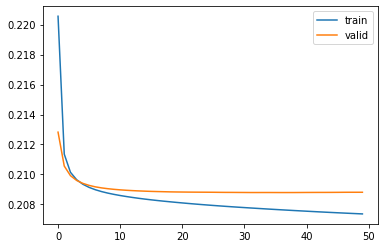

In [4]:
"""
This cell does k-fold cross validation.
Basically, only one of this cell or the cell below is used.
"""

# dataset making for stratified sampling and k-fold
s_data = data_processing_for_stratified_sampling(data,split_num)
x_train = making_x_train_data_list_for_kfold(s_data,split_num)
x_val = making_x_val_data_list_for_kfold(s_data,split_num)
y_train = making_y_train_data_list_for_kfold(s_data,split_num)
y_val = making_y_val_data_list_for_kfold(s_data,split_num)


# create optimizer
optimizer = []
net = []
for i in range(10):
    net.append(create_model_net(n_input,n_hidden,n_output))
    optimizer.append(create_model_optimizer(net[i],alpha))


# for log storage
results_train_data = []
results_valid_data = []

for data_num in range(len(x_train)):
    # for log storage
    results_train = []
    results_valid = []
    # counting
    iteration = 0
    for epoch in range(n_epoch):
        # output of objective function for each batch and storage of classification accuracy
        loss_list = []

        for i in range(0, len(x_train[data_num]), batchsize):
            # batch preparation
            x_train_batch = x_train[data_num][i:i+batchsize,:]
            y_train_batch = y_train[data_num][i:i+batchsize,:]

            # output predicted value
            y_train_batch_pred = net[data_num](x_train_batch)
            # apply objective function to calculate classification accuracy
            loss_train_batch = RPS(y_train_batch, y_train_batch_pred)
            loss_list.append(loss_train_batch.array)

            # slope reset and slope calculation
            net[data_num].cleargrads()
            loss_train_batch.backward()

            # parameter update
            optimizer[data_num].update()

            # count up
            iteration += 1

        # output objective function for training data, and aggregate classification accuracy
        loss_train = np.mean(loss_list)

        # evaluate with validation data every time the epoch is over
        # output predicted values in validation data
        with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
            y_val_pred = net[data_num](x_val[data_num])

        # apply objective function to calculate classification accuracy
        loss_val = RPS(y_val_pred, y_val[data_num])

        # display the result
        print('epoch: {}, iteration: {}, loss (train): {:.4f}, loss (valid): {:.4f}'.format(
            epoch, iteration, loss_train, loss_val.array))

        # log storage
        results_train.append(loss_train)
        results_valid.append(loss_val.array)

    # log storage
    results_train_data.append(results_train)
    results_valid_data.append(results_valid)
    

# calcurate average
results_train_data_all = []
results_valid_data_all = []
results_train_data_all = np.zeros(epoch+1)
results_valid_data_all = np.zeros(epoch+1)
for i in range(split_num):   
    results_train_data_all += results_train_data[i]
    results_valid_data_all += results_valid_data[i]
results_train_data_ave = results_train_data_all / 10
results_valid_data_ave = results_valid_data_all / 10

# output of objective function
plt.plot(results_train_data_ave, label='train')  # set legend with label
plt.plot(results_valid_data_ave, label='valid')  # set legend with label
plt.legend()  # display legend

In [ ]:
"""
This cell outputs the predicted value for test data.
A model is built from scratch to train with all data.
"""

# create optimizer
production_net = create_model_net(n_input,n_hidden,n_output)
production_optimizer = create_model_optimizer(production_net,alpha)

# make dataset
c_data = data_column_conversion(data)
c_data = data_randomization(c_data)
x_train = c_data.drop(["W","D","L"],axis=1)
x_train = x_train.values.astype('float32')
y_train = c_data[["W","D","L"]]
y_train = y_train.values.astype('float32')


# log storage
results_train = []
iteration = 0
for epoch in range(n_epoch):
    loss_list = []
    for i in range(0, len(x_train), batchsize):
        # batch preparation
        x_train_batch = x_train[i:i+batchsize,:]
        y_train_batch = y_train[i:i+batchsize,:]

        # output predicted value
        y_train_batch_pred = production_net(x_train_batch)
        
        # apply objective function to calculate classification accuracy
        loss_train_batch = RPS(y_train_batch, y_train_batch_pred)
        loss_list.append(loss_train_batch.array)

        # slope reset and slope calculation
        production_net.cleargrads()
        loss_train_batch.backward()

        # parameter update
        production_optimizer.update()

        # count up
        iteration += 1
        
    # output objective function for training data, and aggregate classification accuracy
    loss_train = np.mean(loss_list)
    
    # display the result
    print('epoch: {}, iteration: {}, loss (train): {:.4f}'.format(epoch, iteration, loss_train))
    
    # log storage
    results_train.append(loss_train)
    

# input data
path3 = 'predrat_20190708.txt'
data3 = pd.read_csv(path3,sep=',')

# making test dataset
test_data = data3.drop(["num","label"],axis=1)
test_data = test_data.values.astype('float32')

# output predicted value
with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
    test_pred = production_net(test_data)

# unit dataset and predicted value
output_data = np.concatenate([test_data, test_pred.data], 1)
    
# convert to pandas
columns = ['HHATT','HHDEF','HAATT','HADEF','AHATT','AHDEF','AAATT','AADEF','W','D','L']
output = pd.DataFrame(data=output_data, columns=columns, dtype='float64')

# output file
output.to_csv("output.txt", sep=",")